In [26]:
from pathlib import Path
from shutil import copyfile
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numbers

In [12]:
np.random.seed(0)

In [13]:
def crop(img, top, left, height, width):

    return img.crop((left, top, left + width, top + height))

In [14]:
def center_crop(img, output_size):

    if isinstance(output_size, numbers.Number):
        output_size = (int(output_size), int(output_size))
    image_width, image_height = img.size
    crop_height, crop_width = output_size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return crop(img, crop_top, crop_left, crop_height, crop_width)

In [15]:
def five_crop(img, size):

    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    image_width, image_height = img.size
    crop_height, crop_width = size
    if crop_width > image_width or crop_height > image_height:
        msg = "Requested crop size {} is bigger than input size {}"
        raise ValueError(msg.format(size, (image_height, image_width)))

    tl = img.crop((0, 0, crop_width, crop_height))
    tr = img.crop((image_width - crop_width, 0, image_width, crop_height))
    bl = img.crop((0, image_height - crop_height, crop_width, image_height))
    br = img.crop((image_width - crop_width, image_height - crop_height,
                   image_width, image_height))
    center = center_crop(img, (crop_height, crop_width))
    return [tl, tr, bl, br, center]

In [16]:
def ten_crop(img, size, vertical_flip=False):

    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    first_five = five_crop(img, size)

    img_2 = img.transpose(Image.FLIP_LEFT_RIGHT)

    second_five = five_crop(img_2, size)
    return first_five + second_five

In [17]:
level = '200X'
if os.path.isdir('/home/victor/sys866/DiscriminativeActiveLearning/breakhis'):
        train_path = '/home/victor/sys866/DiscriminativeActiveLearning/breakhis/train/{}/'.format(level)
        test_path = '/home/victor/sys866/DiscriminativeActiveLearning/breakhis/test/{}/'.format(level)
else:
    train_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/train/{}/'.format(level)
    test_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/test/{}/'.format(level)
train_files = [str(path) for path in Path(train_path).rglob('*.png')]
test_files = [str(path) for path in Path(test_path).rglob('*.png')]

In [18]:
def load_breakhis(level, mode='single'):

    assert mode in ['single', 'five', 'ten']
    
    if os.path.isdir('/home/victor/sys866/DiscriminativeActiveLearning/breakhis'):
        train_path = '/home/victor/sys866/DiscriminativeActiveLearning/breakhis/train/{}/'.format(level)
        test_path = '/home/victor/sys866/DiscriminativeActiveLearning/breakhis/test/{}/'.format(level)
    else:
        train_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/train/{}/'.format(level)
        test_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/test/{}/'.format(level)

    train_files = [str(path) for path in Path(train_path).rglob('*.png')]
    test_files = [str(path) for path in Path(test_path).rglob('*.png')]

    X_train, y_train = parse_breakhis_files(train_files, mode)
    X_test, y_test = parse_breakhis_files(test_files, mode)

    X_train = np.array(X_train).astype('float32') / 255
    X_test = np.array(X_test).astype('float32') / 255
    
    # shuffle the train data:
    perm = np.random.permutation(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    # shuffle the test data:
    perm = np.random.permutation(X_test.shape[0])
    X_test = X_test[perm]
    y_test = y_test[perm]
    
    return (X_train, y_train), (X_test, y_test)

In [19]:
def get_breakhis_label(file):
    if 'benign' in file:
        return 0
    else:
        return 1

In [20]:
def parse_breakhis_files(files, mode='single'):
    modes = {
        'single': (center_crop, 1),
        'five' : (five_crop, 5),
        'ten' : (ten_crop, 10)
    }
    
    croper, multiplier = modes[mode]
    
    X = []
    y = []
    
    for file in files:
        img = Image.open(file)
        imgs = croper(img, (150, 150))
        if mode is not 'single':
            np_imgs = [np.array(pic) for pic in imgs]
            X.extend(np_imgs)
            y.extend(multiplier * [get_breakhis_label(file)])
        else:
            np_imgs = np.array(imgs)
            X.append(np_imgs)
            y.append(get_breakhis_label(file))

    X = np.asarray(X, dtype='uint8')
    y = np.asarray(y, dtype='uint8')
    return X, y

In [30]:
(X_train, y_train), (X_test, y_test) = load_breakhis(level, 'ten')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16100, 150, 150, 3), (16100,), (4030, 150, 150, 3), (4030,))

In [31]:
base_path = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/numpy/{}'.format(level)
path_format = base_path + '/{}'
p = Path(base_path)
p.mkdir(parents=True, exist_ok=True)

In [32]:
np.save(path_format.format('X_train_ten'), X_train)
np.save(path_format.format('y_train_ten'), y_train)
np.save(path_format.format('X_test_ten'), X_test)
np.save(path_format.format('y_test_ten'), y_test)

In [33]:
(X_train, y_train), (X_test, y_test) = load_breakhis(level, 'five')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8050, 150, 150, 3), (8050,), (2015, 150, 150, 3), (2015,))

In [34]:
np.save(path_format.format('X_train_five'), X_train)
np.save(path_format.format('y_train_five'), y_train)
np.save(path_format.format('X_test_five'), X_test)
np.save(path_format.format('y_test_five'), y_test)

In [35]:
(X_train, y_train), (X_test, y_test) = load_breakhis(level, 'single')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1610, 150, 150, 3), (1610,), (403, 150, 150, 3), (403,))

In [36]:
np.save(path_format.format('X_train_single'), X_train)
np.save(path_format.format('y_train_single'), y_train)
np.save(path_format.format('X_test_single'), X_test)
np.save(path_format.format('y_test_single'), y_test)

In [37]:
def load_breakhis_from_np(level, mode):
    assert mode in ['single', 'five', 'ten']
    
    path_format = '/home/ens/AM90950/sys866/DiscriminativeActiveLearning/data/breakhis/numpy/{}/'.format(level)
    x_train_file = 'X_train_{}.npy'.format(mode)
    y_train_file = 'y_train_{}.npy'.format(mode)    
    x_test_file = 'X_test_{}.npy'.format(mode)  
    y_test_file = 'y_test_{}.npy'.format(mode)
    
    X_train = np.load(path_format + x_train_file)
    y_train = np.load(path_format + y_train_file)
    X_test = np.load(path_format + x_test_file)
    y_test = np.load(path_format + y_test_file)
    
    return (X_train, y_train), (X_test, y_test)    

In [38]:
(X_train, y_train), (X_test, y_test) = load_breakhis_from_np(level, 'single')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1610, 150, 150, 3), (1610,), (403, 150, 150, 3), (403,))

In [39]:
(X_train, y_train), (X_test, y_test) = load_breakhis_from_np(level, 'five')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8050, 150, 150, 3), (8050,), (2015, 150, 150, 3), (2015,))

In [40]:
(X_train, y_train), (X_test, y_test) = load_breakhis_from_np(level, 'ten')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16100, 150, 150, 3), (16100,), (4030, 150, 150, 3), (4030,))

In [41]:
for i in range(50):
    print(y_train[i])

0
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
0
1
1
1
0
1
0
1
0
0
0
0
1
1
0
1
0
1
1
0
1
1
0
1
1


In [42]:
for i in range(3989):
    print(y_test[i])

1
1
1
1
1
1
0
0
0
0
1
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
1
1
1
0
0
0
1
1
1
1
0
0
0
1
0
1
0
1
0
1
0
1
0
1
1
1
0
1
1
0
0
1
0
1
1
1
0
1
0
1
1
0
0
1
0
1
1
0
0
0
1
1
1
0
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
0
0
1
1
1
0
1
0
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
0
1
1
1
1
0
1
0
1
1
0
1
0
1
1
1
1
1
1
1
1
0
1
1
0
0
1
1
1
1
0
1
1
0
0
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
0
1
1
0
0
0
1
1
0
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
1
1
1
0
1
0
1
0
0
1
1
1
1
1
1
1
1
0
1
0
1
0
0
1
1
1
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
1
1
0
1
1
0
0
1
0
1
0
1
0
1
1
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
0
0
1
1
0
1
0
1
0
0
1
1
1
1
0
1
1
0
1
1
1
0
1
1
0
0
0
1
1
0
0
1
1
1
1
0
0
0
0
0
0
0
0
1
1
0
0
1
0
0
1
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
0
0
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
0
1
1
0
0
1
1
0
1
1
1
1
0
1
1
1
0
1
1
1
0
1
0
0
1
0
0
0
1
1
1
1
1
1
0
0
1
0
1
0
0
0


In [43]:
X_train[0]

array([[[0.7058824 , 0.6862745 , 0.7137255 ],
        [0.7058824 , 0.6862745 , 0.70980394],
        [0.7176471 , 0.6901961 , 0.72156864],
        ...,
        [0.7176471 , 0.7058824 , 0.73333335],
        [0.6901961 , 0.6784314 , 0.7137255 ],
        [0.67058825, 0.64705884, 0.69411767]],

       [[0.7137255 , 0.69411767, 0.7176471 ],
        [0.7294118 , 0.70980394, 0.73333335],
        [0.7372549 , 0.7176471 , 0.7411765 ],
        ...,
        [0.69411767, 0.68235296, 0.7176471 ],
        [0.68235296, 0.67058825, 0.7137255 ],
        [0.6784314 , 0.654902  , 0.70980394]],

       [[0.7176471 , 0.70980394, 0.7294118 ],
        [0.73333335, 0.7137255 , 0.7372549 ],
        [0.7411765 , 0.72156864, 0.74509805],
        ...,
        [0.6901961 , 0.6784314 , 0.72156864],
        [0.6784314 , 0.6627451 , 0.7176471 ],
        [0.68235296, 0.654902  , 0.7176471 ]],

       ...,

       [[0.5411765 , 0.44705883, 0.57254905],
        [0.56078434, 0.46666667, 0.60784316],
        [0.56078434, 0

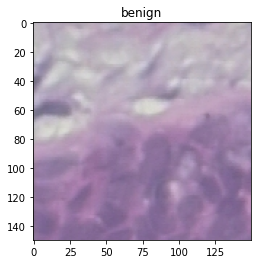

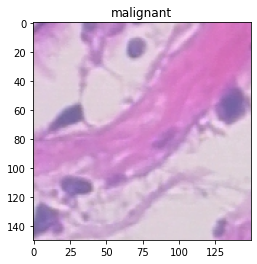

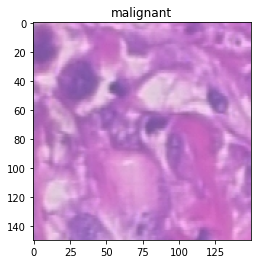

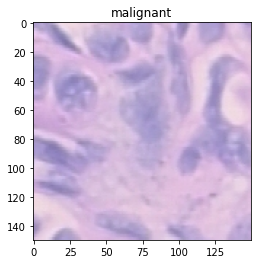

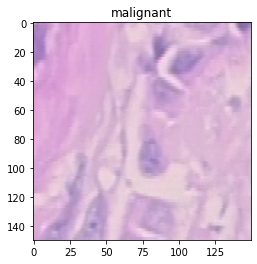

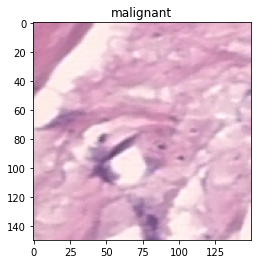

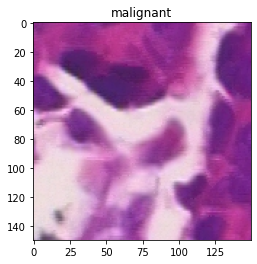

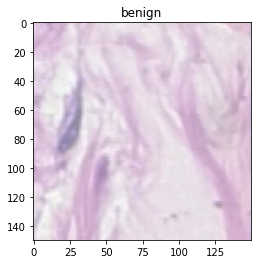

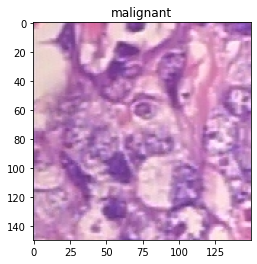

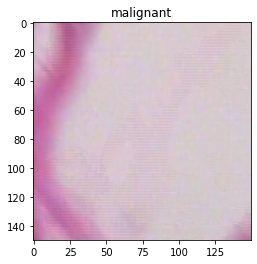

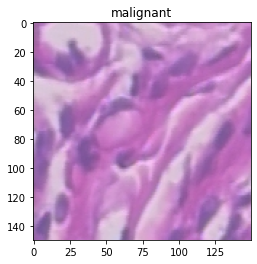

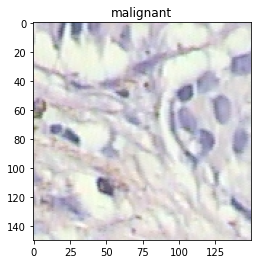

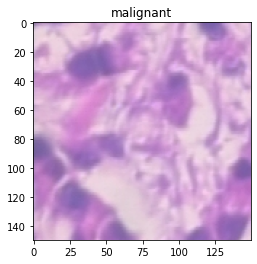

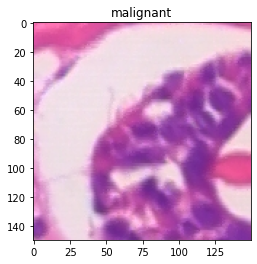

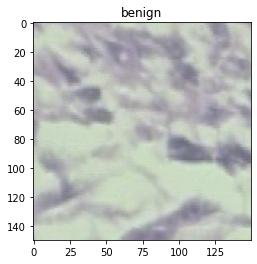

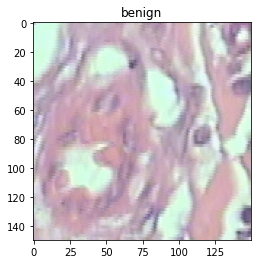

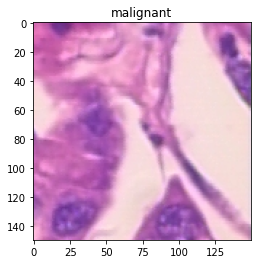

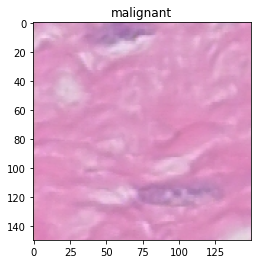

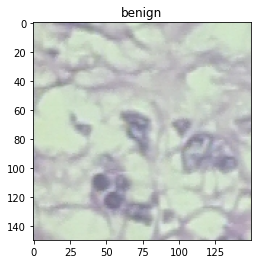

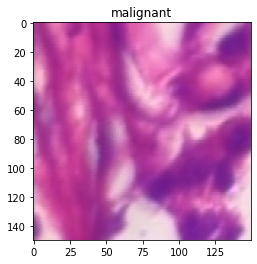

In [49]:
for i in range(20):
    plt.figure()
    plt.imshow(X_train[i])
    y = y_train[i]
    if y == 0:
        lbl = 'benign'
    else:
        lbl = 'malignant'
    plt.title(lbl)